# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [1]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt
import os
from scipy.misc import comb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

from IPython.display import display, HTML


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

cwd = os.getcwd()


Loaded!


We will be performing our exercise on the German yield curve from Quandl. Free data is available from January 2010 to December 2014.

,1y,1y1y,2y1y,3y1y,4y1y,5y1y,6y1y,7y3y,10y2y,12y3y,15y5y,20y5y,25y5y
2016-12-02,-19.9,-11.473644,-1.339755,24.170277,52.291037,84.434963,114.197903,158.556919,185.599179,189.090715,170.824606,141.879576,131.076548
2016-12-05,-19.8,-11.072702,4.868219,27.809996,57.175963,89.958432,120.581964,163.441031,190.377335,193.582286,175.318243,145.853867,134.909486
2016-12-06,-19.5,-9.067368,9.990201,32.193333,67.775274,96.881902,126.873994,169.525142,198.389960,201.031710,181.805516,152.605285,141.109486
2016-12-07,-19.5,-10.070506,5.976524,34.080928,60.706918,92.989300,123.081964,165.941031,193.555491,196.765427,178.505516,148.653867,138.543610
2016-12-08,-20.3,-12.254836,4.455971,36.488736,59.378610,95.443637,128.104069,172.584329,203.893365,206.579981,188.852794,158.913790,149.114229


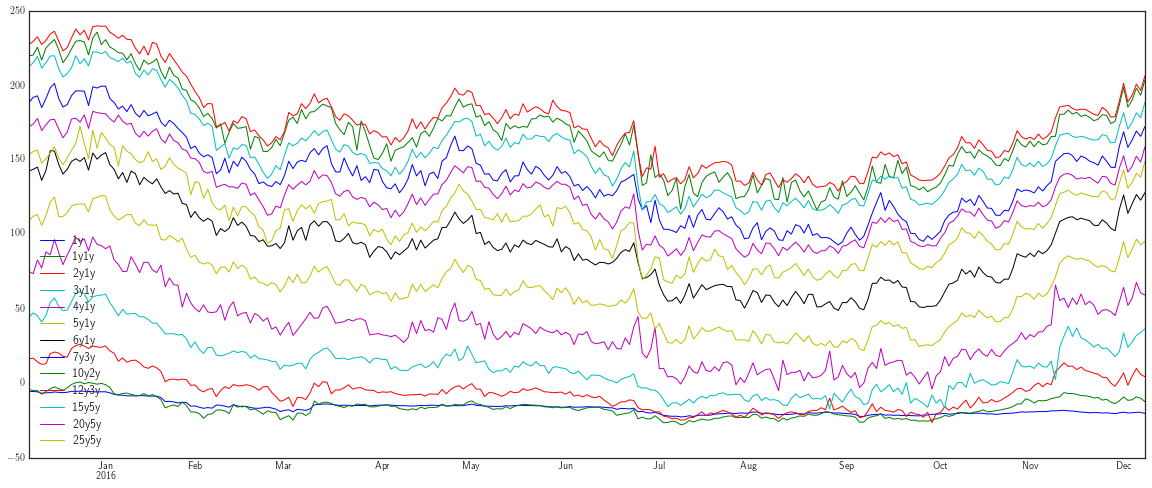

In [98]:

currency = "EUR"
"""
rawData = quandl.get("YC/"+country, authtoken="hHmwzKyDyqaHhJLF1eFe")


#get data from pickle 
#rawData = pd.read_pickle("%s/depo/rawData"%cwd)[dt.datetime(2007,1,1):]
#rawData = rawData.astype(float)

#Let's focus on 2y, 5y, 7y, 10y, 20y and 30y
assets = ['2-Year', '5-Year', '7-Year', '10-Year']
#assets = ['2 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']
rawData = rawData[assets]

#convert to bps
rawData *= 100

##### BOOK DATA #####

rawData = pd.read_csv("bookData.csv", sep=",")

rawData["Date"] = pd.to_datetime(rawData["Date"], infer_datetime_format=True)
rawData.set_index("Date", drop=True, inplace=True)

start = dt.datetime(2010, 1, 4)
end = dt.datetime(2011, 10, 3)

#### SWAP DATA ####
"""
usd = pd.read_pickle("%s/depo/data/%s"%(cwd,"fwd"+"USD"))
eur = pd.read_pickle("%s/depo/data/%s"%(cwd,"fwd"+"EUR"))
assets = list(set(usd.columns.values) & set(eur.columns.values))
assets.sort(key=lambda x: len(x.split("y")))
assets.sort(key=lambda x: int(x.split("y")[0]))
usd = usd[assets]
eur = eur[assets]
rawData = eur[::-1]
#rawData = rawData[::-1]

#########

rawData = rawData.astype(float)
assets = rawData.columns.values

start = dt.datetime(2015, 12, 8)
end = dt.datetime(2016, 12, 8)


data = rawData[start:end]

display(data.tail())
rawplot = data.plot(figsize=(20,8))

## change dates

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

Further down the line, we will also need k-factor residuals (residuals found by reconstructing the data using only k-1 factors). We write this helper function and use it in the staticPCA function now, to make things a bit easier.

(Edit: The re-orientation function was written after the fact. Considerable time was spent on automating a way to re-orient the PCs post ante. However, given that yield curve dynamics are understood in that PC1 is level, PC2 slope and PC3 curvature, we can write a reorient function. The reorient function calculates correlations between the level, slope, fly and the individual PCs and re-orients the PCs as they should be. )

In [99]:
def kfacReconstruct(data, evTable, k=3, cols = [], auto= 0):
    ## Auto reorients EVs and PCs
    ## Pick securities to receive data for. If no input, do all. 
    if cols ==[]: 
        cols = data.columns.values
    
    # Returns k-factor reconstruction when given the data and Eigenvectors
    
    result = {}
    
    totFactors = len(evTable.columns.values)
    if totFactors < k:
        print ("Error! Total factors are less than k.")
        return
    
    # get demeaned data
    meanVals = data.mean()
    demeaned = data - meanVals
    
    #reconstruct historical factor time series
    factorTS = demeaned.dot(evTable)
    if auto != 0:
        reOrient = pcReorient(data, factorTS, tol=auto)[:totFactors]
        newEVs = evTable.copy()
        newFactors = factorTS.copy()
        for i in range(totFactors):
            newEVs.loc[:, evTable.columns[i]] *= reOrient[i]
            newFactors.loc[:, factorTS.columns[i]] *= reOrient[i]
        factorTS = newFactors
        evTable = newEVs

    #inverse of eigenvectors
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)

    #drop columns to adjust for k factors
    factorTS.drop(factorTS.columns[range(len(factorTS.columns.values))[k:]], axis=1, inplace=True)
    
    #drop rows to adjust for k factors
    invEV.drop(invEV.index[range(len(invEV.index.values))[k:]], axis=0, inplace=True)
    
    #### Reconstruction using k factors
    kRebuild = factorTS.dot(invEV)
    kResiduals = demeaned - kRebuild
    reRaw = kRebuild + meanVals
    
    result["factorTS"] = factorTS
    result["rebuildRaw"] = reRaw[cols]
    result["residuals"] = kResiduals[cols]
    
    return result, evTable
    
def pcReorient(data, factors, tol=2):
    lenData = len(data.columns.values)
    numCurves = lenData//2
    numFlies = comb(lenData, 3)    
    
    pc1corr, pc2corr, pc3corr = 1, 1, 1
        
    if tol > numCurves or tol > numFlies:
        print ("Error.")
        return
    numFactors = len(factors.columns.values)
    if numFactors >=1:
        ## check pc1
        split = lenData//tol
        pc1check = pd.concat([data.ix[:,j*split] for j in range(tol)], axis=1)
        pc1corr = pc1check.corrwith(factors["PC1"]).mean()
    if numFactors >=2:
        ## check pc2
        pc2check = pd.concat([data.ix[:,-i]-data.ix[:,i] for i in range(numCurves)], axis=1)
        pc2corr = pc2check.corrwith(factors["PC2"]).mean()
    if numFactors >=3:
        ## check pc3
        pc3check = data.ix[:,numCurves]*2 - data.ix[:,0] - data.ix[:,-1]
        pc3corr = factors["PC3"].corr(pc3check).mean()
    
    
    return np.sign([pc1corr, pc2corr, pc3corr])

def staticPCA(data, n=3, freq=1, corrW = 12, autoOrient=2, plot=True):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM

    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        evTable.insert(i, "PC"+str(i+1), epairs[i][1])

    ## Reconstruct
    reConResult = kfacReconstruct(raw, evTable, n, auto=autoOrient)
    reconstructed = reConResult[0]
    evTable = reConResult[1]
    results["evecs"] = evTable
    resid = reconstructed["residuals"]
    facTS = reconstructed["factorTS"]
    reRaw = reconstructed["rebuildRaw"]
    
    results["resid"] = resid
    results["facTS"] = facTS
    results["reRaw"] = reRaw
    

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    
    return results




## Playing around with the function results

Let's load our German Yield curve data into this function and see what we get.

In [100]:
print("Eigenvectors:")
pca1 = staticPCA(data, freq=1, n=1)
pca2 = staticPCA(data, freq=1, n=2)
pca3 = staticPCA(data, freq=1, n=3)
display(pca3["evecs"])
print("Eigenvalues:")
display(pca3["evals"])

Eigenvectors:


,PC1,PC2,PC3
1y,0.045800,0.004730,0.014162
1y1y,0.067281,-0.162686,-0.399643
2y1y,0.138811,-0.306985,-0.508868
3y1y,0.221820,-0.319197,-0.229788
4y1y,0.285992,-0.462971,-0.042439
5y1y,0.314968,-0.310268,0.180280
6y1y,0.326466,-0.245228,0.374297
7y3y,0.321873,-0.050404,0.499257
10y2y,0.339523,0.233340,-0.104151
12y3y,0.341305,0.332298,0.028572


Eigenvalues:


[97.754932324718183, 0.92066246483392711, 0.33605468086159451]

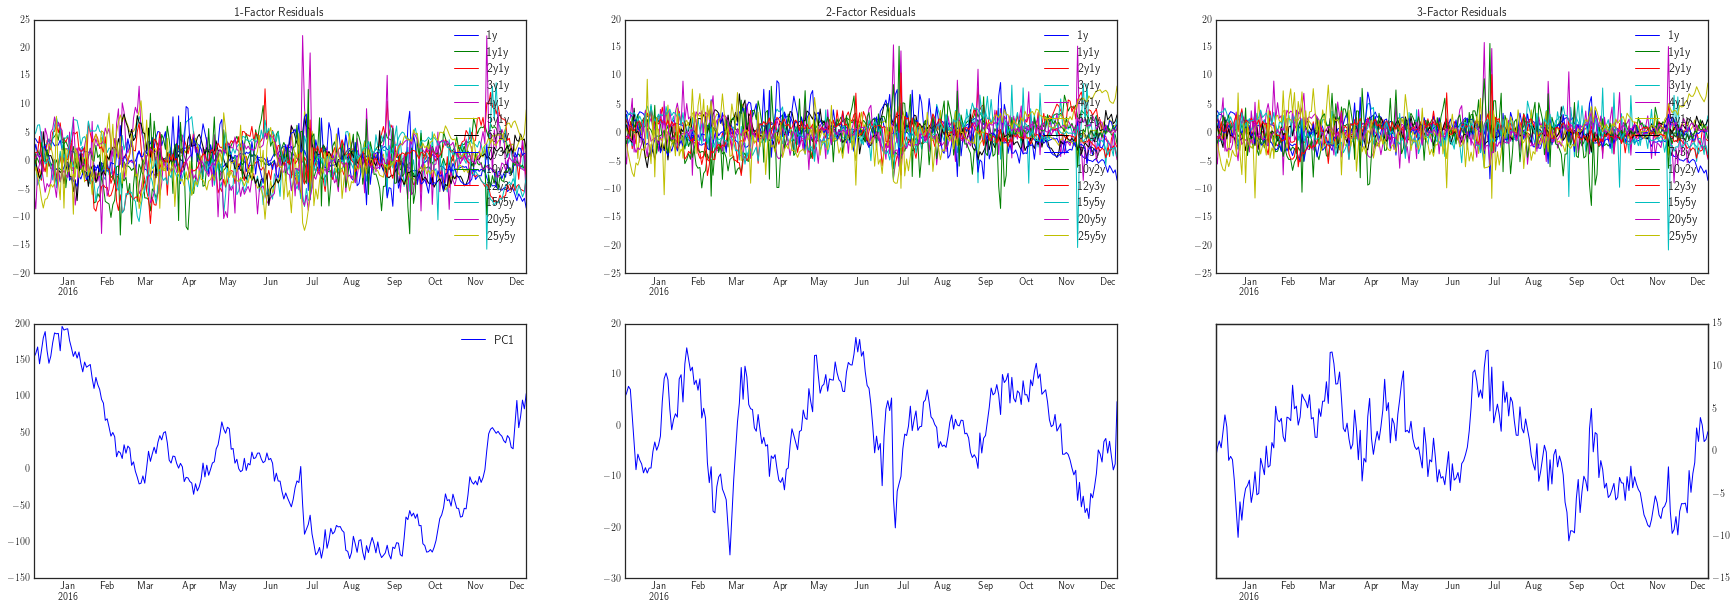

In [103]:
# Plot it.

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pca1["resid"].plot(ax=axes[0, 0], title="1-Factor Residuals")
pca1["facTS"].plot(ax=axes[1, 0])

pca2["resid"].plot(ax=axes[0, 1], title="2-Factor Residuals")
pca2["facTS"]["PC2"].plot(ax=axes[1, 1])

pca3["resid"].plot(ax=axes[0, 2], title="3-Factor Residuals")
pca3["facTS"]["PC3"].plot(ax=axes[1, 2], secondary_y="PC3")

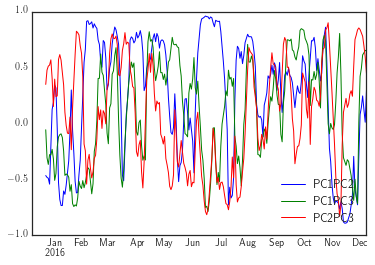

In [104]:
pca3["facCR"].plot()

# Residuals

We create a one page summary of the residuals, which might potentially highlight attractive trades.


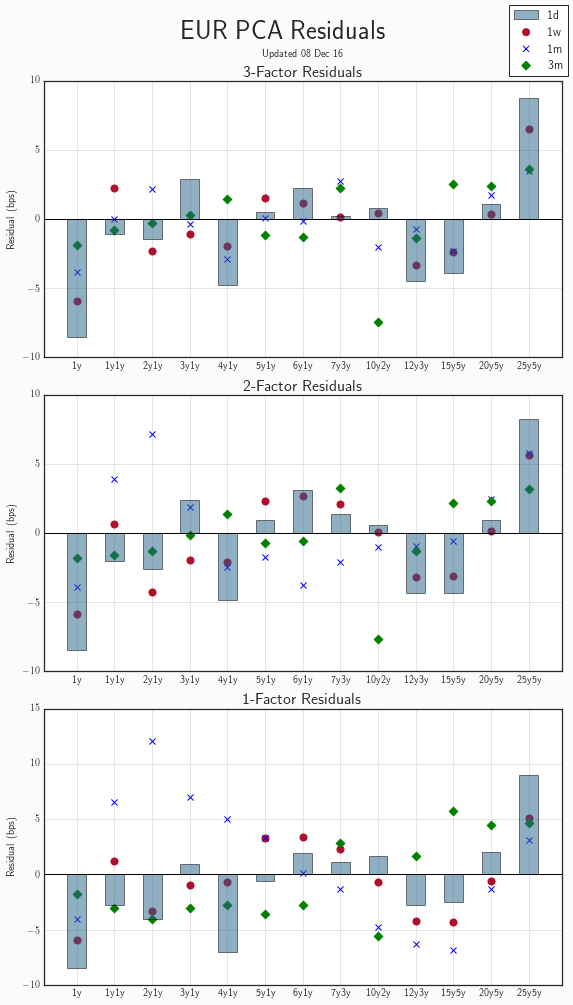

In [105]:
########### Residuals ############
## LEVEL
xvals = range(len(assets))

relVal1 = pd.DataFrame()
relVal1 = pca1["resid"].ix[[-1, -5, -20, -60]]
relVal1.index = ["1d", "1w", "1m", "3m"]
relVal1 = relVal1.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 14), dpi=400, facecolor="#fbfbfb")
fig.suptitle("%s PCA Residuals"%currency, fontsize=26)

### 1-Factor PCA residual 
ax1 = plt.subplot2grid((3, 1), (2, 0), colspan=1)
xvals = range(len(assets))
lday=ax1.bar(xvals, relVal1["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax1.set_xticks(xvals)
ax1.set_xticklabels(assets)
plt.grid()
s = 25
lwk= ax1.scatter(xvals, relVal1["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
lmnth=ax1.scatter(xvals, relVal1["1m"], color='b', marker = "x", s=1.5*s, label="1m")
lquart=ax1.scatter(xvals, relVal1["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax1.axhline(0, color="black")
ax1.set_title("1-Factor Residuals", fontsize="16")
#ax1.set_axis_bgcolor('#f8fcff')
ax1.set_ylabel("Residual (bps)")

## 2-Factor PCA residual

relVal2 = pd.DataFrame()
relVal2 = pca2["resid"].ix[[-1, -5, -20, -60]]
relVal2.index = ["1d", "1w", "1m", "3m"]
relVal2 = relVal2.transpose()

ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1)
ax2.bar(xvals, relVal2["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax2.set_xticks(xvals)
ax2.set_xticklabels(assets)
plt.grid()
s = 25
ax2.scatter(xvals, relVal2["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax2.scatter(xvals, relVal2["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax2.scatter(xvals, relVal2["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax2.axhline(0, color="black")
ax2.set_title("2-Factor Residuals", fontsize="16")
#ax2.set_axis_bgcolor('#f8fcff')
ax2.set_ylabel("Residual (bps)")

## 3-Factor PCA residual


relVal3 = pd.DataFrame()
relVal3 = pca3["resid"].ix[[-1, -5, -20, -60]]
relVal3.index = ["1d", "1w", "1m", "3m"]
relVal3 = relVal3.transpose()

ax3 = plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax3.bar(xvals, relVal3["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax3.set_xticks(xvals)
ax3.set_xticklabels(assets)
plt.grid()
s = 25
ax3.scatter(xvals, relVal3["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax3.scatter(xvals, relVal3["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax3.scatter(xvals, relVal3["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax3.axhline(0, color="black")
ax3.set_title("3-Factor Residuals", fontsize="16")
#ax3.set_axis_bgcolor('#f8fcff')
ax3.set_ylabel("Residual (bps)")


lastDate = data.index[-1].strftime("%d %b %y")
plt.text(0.5, 1.1,'Updated %s'%lastDate, ha='center', va='center', transform=ax3.transAxes, fontsize=10)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.figlegend([lday, lwk, lmnth, lquart], ["1d", "1w", "1m", "3m"], frameon=True,loc="upper right" )
plt.savefig("%s/depo/%s-PCA Residuals - %s"%(cwd, currency, lastDate))


At the end of the exercise, we will dive quite a bit deeper into the results. For now, let's go back implement a rolling PCA using our staticPCA function.

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [106]:
def rollingPCA(data, lb=30, n=3, corrW=12, skip=1):
    """
    For now, this function returns a data frame with time series of eigenvalues and eigenvectors of a rolling PCA. 
    """

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    eVecCols = [pc+asset for pc in pcCols for asset in assets]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))
    alleVectors = pd.DataFrame(index=data.index.values[lb:], columns = eVecCols)
    
    ### Rolling PCA - Loop and save data.
    
    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, corrW=corrW)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        tempDict = {}
        for pc in pcCols:
            factor = eigenvectors[pc]
            #print (i, pc, factor.tolist())
            for k in range(len(assets)):
                alleVectors.set_value(currDate, pc+assets[k], factor[k])
    
    #### Split data into PC1, PC2, PC3 and drop NAs.
    
    accumEvals = accumEvals.dropna()

    grouped = alleVectors.groupby(lambda x: x[:3], axis=1)
    
    for pc in pcCols:
        accumEvecs[pc] = grouped.get_group(pc).dropna()
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    accumEvals.columns = pcCols
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    ## Secret
    rollResult["master"] = alleVectors.dropna()
    
    return rollResult
            
pcaResults = rollingPCA(data)
print ("Done!")


Done!


Let's see what the eigenvalues and eigenvectors look like over time. Their stability would highlight the effectiveness of the PCA based model for this particular set of data.

Eigenvalues:


,PC1,PC2,PC3
2016-12-02,95.8013,2.22162,1.44776
2016-12-05,95.0159,2.46756,1.89713
2016-12-06,94.5297,2.65895,2.1439
2016-12-07,94.2302,2.79069,2.27466
2016-12-08,93.9932,2.92321,2.39245


####### PC1 historical ########
                     1y       1y1y      2y1y      3y1y      4y1y      5y1y  \
2016-12-02   0.00539412  0.0607938  0.151283  0.237956  0.302676  0.351538   
2016-12-05   0.00327454  0.0548518  0.140348  0.237578  0.297133  0.351673   
2016-12-06   0.00119936  0.0469027   0.13054  0.230074  0.291054  0.349609   
2016-12-07 -0.000853267  0.0392661  0.124941  0.216716  0.296732   0.34634   
2016-12-08  -0.00240452  0.0320238  0.116075  0.218095  0.289897  0.341321   

                6y1y      7y3y     10y2y     12y3y     15y5y     20y5y  \
2016-12-02  0.368155   0.34172  0.301536  0.286502  0.283677  0.289654   
2016-12-05  0.368407  0.344816   0.30399  0.289255  0.285525  0.290158   
2016-12-06  0.366713  0.347782  0.310149  0.294873  0.291192  0.291425   
2016-12-07  0.362011  0.348675  0.316851  0.301751  0.296606  0.291644   
2016-12-08  0.358395  0.349392  0.322916  0.306979  0.302094  0.292659   

               25y5y  
2016-12-02   0.33449  
2016-12-

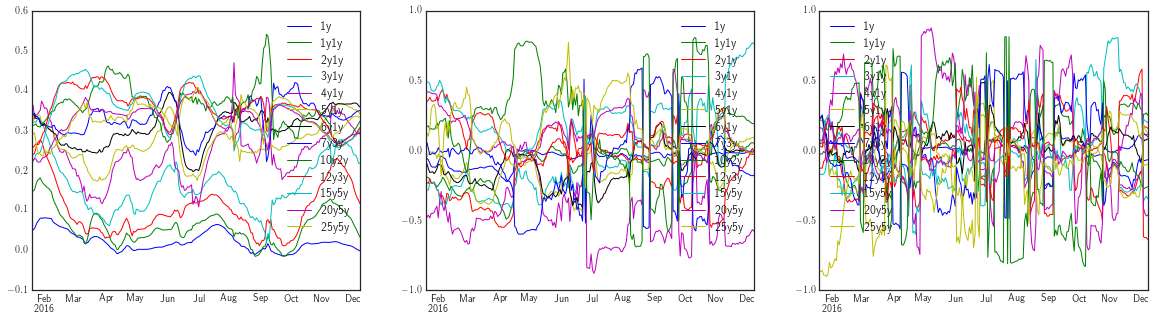

In [107]:

print ("Eigenvalues:")
display(pcaResults["evalues"].tail())
print ("####### PC1 historical ########")
print (pcaResults["evectors"]["PC1"].tail())
print ("####### PC2 historical ########")
print (pcaResults["evectors"]["PC2"].tail())
print ("####### PC3 historical ########")
print (pcaResults["evectors"]["PC3"].tail())

pc1raw = pcaResults["evectors"]["PC1"]
pc2raw = pcaResults["evectors"]["PC2"]
pc3raw = pcaResults["evectors"]["PC3"]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

pc1raw.plot(ax=axes[0])
pc2raw.plot(ax=axes[1])
pc3raw.plot(ax=axes[2])


Wait, what? 

Ok, so this is because the static PCAs that are being run sometimes will generate eigenvectors that are in the opposite orientation of the previous eigenvector. But this isn't really a point to worry about. Eigenvectors would be equivalent to their negatives. What we can do, however, is to try our best to flip the eigenvectors to the direction that makes sense. 

The following function tries to achieve this task. It is not perfect, but it does not affect the purposes of the exercise (which is to determine the stability of the EVs). The stability is discernible well enough with the smoothing applied.

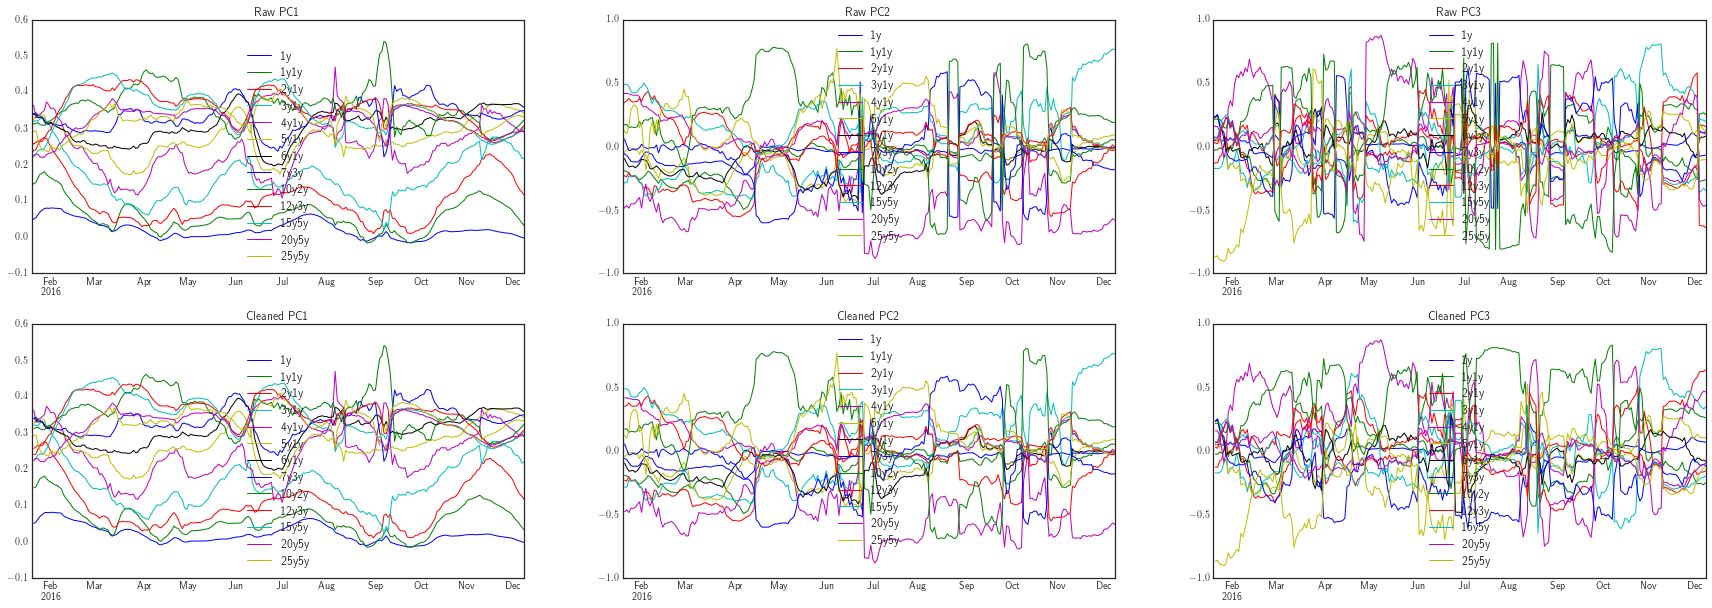

In [111]:

def cleanPCs(input, smoothing=0):
    newdf = pd.DataFrame(index=input.index.values, columns=input.columns.values)
    flag = "flipped"

    for i in range(1, len(input)):
        if i ==1:
            prevfactor = input.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = input.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])
        
        if orig > new:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*input.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], input.iloc[i, s])
                flag = "same"
    
    if smoothing==1:
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2.5).all(axis=1)]

        
    return newdf
            

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pc1raw.plot(ax=axes[0, 0], title="Raw PC1")
cleanPCs(pc1raw).plot(ax=axes[1, 0], title="Cleaned PC1")

pc2raw.plot(ax=axes[0, 1], title="Raw PC2")
cleanPCs(pc2raw).plot(ax=axes[1, 1], title="Cleaned PC2")

pc3raw.plot(ax=axes[0, 2], title="Raw PC3")
cleanPCs(pc3raw).plot(ax=axes[1, 2], title="Cleaned PC3")

Ah, much better. As we can see, the PCs are generally quite stable, with stability increasing with order. 

What about the Eigenvalues?

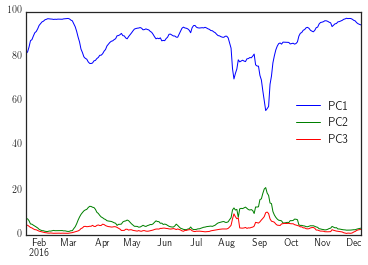

In [110]:
pcaResults["evalues"].plot()

Not too bad. 

# Snapshots over time

Alternatively, we can look at a snapshot of the eigenvectors and values at different points in time. This will hopefully provide a bit more insight than the previous rolling PCA charts which were quite noisy. This function will generate a subset of the rolling PCA results, showing only snapshots on an input set of dates and a lookback period on the rolling PCA.

In [114]:
lb = 90
testDates = [data.index.values[i] for i in range(lb, len(data.index.values)-lb, 10)]
target = pd.DataFrame(index=testDates)
print (testDates)

orig = pcaResults["master"]

result = target.join(orig)
#print (result)

def pcaSnapshot(dates, data, lb=30, n=3,orient=True, vec=[], tol=1.5):
    # Returns tuple of evalues and a dict of evectors.
    reorient = len(dates)*[1]
    
    pcaResults = rollingPCA(data, lb=lb, n=n)
    orig = pcaResults["master"]
    evectors = pd.DataFrame(index=dates).join(orig)
    
    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])

    pcCols = evalues.columns.values
    
    grouped = evectors.groupby(lambda x: x[:3], axis=1)
    
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))
    flag = 0
    for pc in pcCols:
        
        if flag == 0 and orient :
            flag = 1
            temp = grouped.get_group(pc).dropna()
            temp['orient'] = temp.applymap(np.sign).sum(axis=1)
            reorient = temp["orient"].apply(lambda x: (-1)**((np.abs(x-temp["orient"].mean())/temp["orient"].std()<tol)-1))
        
        factors = grouped.get_group(pc).dropna()
            
        accumEvecs[pc] = factors.mul(reorient, axis=0)
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    
    return evalues, accumEvecs

testSnap = pcaSnapshot(testDates, data, orient=True, tol=1.5)

print ("Done")

[numpy.datetime64('2016-04-12T00:00:00.000000000'), numpy.datetime64('2016-04-26T00:00:00.000000000'), numpy.datetime64('2016-05-10T00:00:00.000000000'), numpy.datetime64('2016-05-24T00:00:00.000000000'), numpy.datetime64('2016-06-07T00:00:00.000000000'), numpy.datetime64('2016-06-21T00:00:00.000000000'), numpy.datetime64('2016-07-05T00:00:00.000000000'), numpy.datetime64('2016-07-19T00:00:00.000000000'), numpy.datetime64('2016-08-02T00:00:00.000000000')]
Done


Let's display the results.

,PC1,PC2,PC3
2016-04-12,86.864,5.67551,3.46772
2016-04-26,87.7663,6.56305,2.45448
2016-05-10,92.5157,3.79625,1.55406
2016-05-24,87.7691,6.20869,2.52516
2016-06-07,89.8668,3.57173,2.52943
2016-06-21,92.6282,2.30608,1.9048
2016-07-05,92.6004,2.63348,1.59549
2016-07-19,90.8759,3.97762,1.96104
2016-08-02,88.1819,5.7936,2.83757


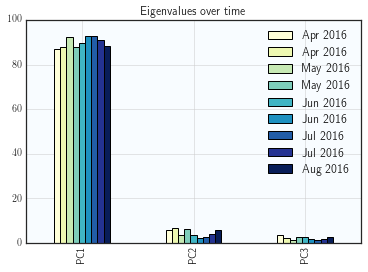

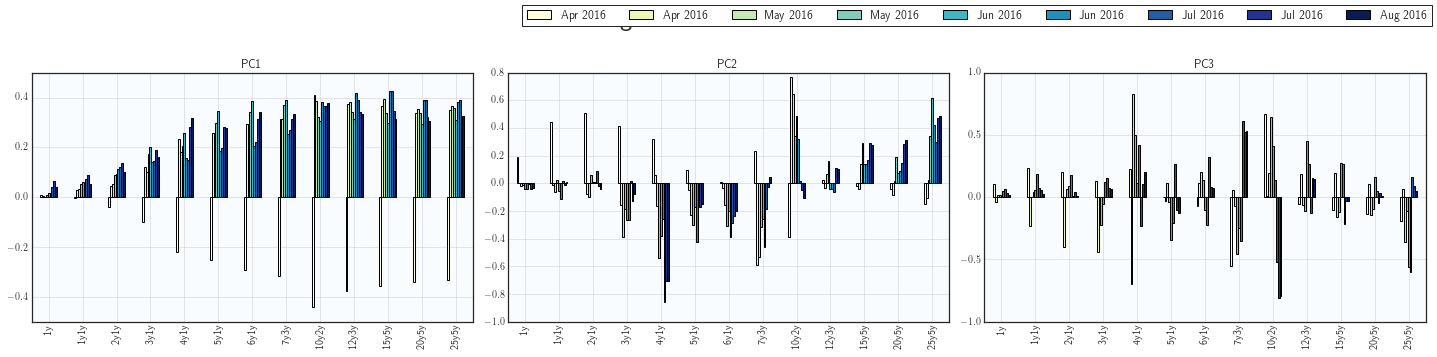

In [116]:
evalues = testSnap[0]
evectors = testSnap[1]

## Eigenvalues
display(evalues)
dateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]
ax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, dateStrings, loc="best")
ax.set_axis_bgcolor("#f8fcff")

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)


for i in range(len(evectors.keys())):
    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)
    lines, labels = ax.get_legend_handles_labels()
    ax.set_axis_bgcolor('#f8fcff')
    ax.set_title("PC"+str(i+1))
    #ax.legend(lines, dateStrings, loc="best")

fig.suptitle("Eigenvectors over time", fontsize="26")
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.figlegend(lines, dateStrings, frameon=True,loc="upper right", ncol=len(dateStrings))




Okay, phew! So except for a few bars (Apr 16) in PC2, things look ok... 

# Generating weights for curve and fly trades

The next thing to do is create a function that would generated trades that are PC hedged. 

In [117]:
curve = "2s10s"
fly = "2s5s7s"
import string


def returnNotWgts(trade, evectors, bpvs=0):
    ### Returns notionals to use in trades
    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
    tenors = [str(i)+"y" for i in tenors]
    ## re-index evectors:
    newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
    evectors.index = newIndex
    
    if bpvs == 0:
        return returnRiskWgts(trade, evectors)
    
    ## curves
    if len(tenors)==2:
        ## longer tenor = 1
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-bpvs[long]/bpvs[short]*el/es, 1]
    
    if len(tenors)==3:
        ## get belly and wings. Assume belly = 1.
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        ## get eigenvector subset
        
        #LHS
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(evectors).ix[:,:-1].transpose()
        wingRisk = np.diag([bpvs[x] for x in wings])
        coeff = wingFactors.dot(wingRisk)
        invcoeff = np.linalg.pinv(coeff)
        
        #RHS
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(evectors).ix[:,:-1].transpose()
            
        bellyFactor.loc[:] *= -bpvs[belly]
                
        wingWeights = list(np.ravel(invcoeff.dot(bellyFactor)))
        wingWeights.insert(1, 1)
        
        
        return wingWeights
    else:
        print("Oops. Not enough, or too many instruments.")
        
        
    return

def returnRiskWgts(trade, evectors):
    ### Returns notionals to use in trades
    tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
    tenors = [str(i)+"y" for i in tenors]
    ## re-index evectors:
    newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
    evectors.index = newIndex

    if len(tenors)==2:
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-el/es, 1]
    
    if len(tenors)==3:
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(evectors).ix[:,:-1].transpose()
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(evectors).ix[:,:-1].transpose()
        
        invcoeff = np.linalg.pinv(wingFactors)
        bellyFactor.loc[:] *= -1
        rhs = invcoeff.dot(bellyFactor)
        rhs = list(np.ravel(rhs))
        rhs.insert(1, 1)
        
        return rhs
    else:
        print("Oops. Not enough, or too many instruments.")
    return

        
def bpvWgts(trade, bpvs):
    return


Testing it here:

In [118]:
## WORKS FOR PAR, NOT FOR FLIES. 

print (returnNotWgts(curve, pca3["evecs"], pv01s))
print (returnRiskWgts(fly, pca3["evecs"]))
print (returnNotWgts(fly, pca3["evecs"],pv01s))


NameError: name 'pv01s' is not defined

We are going to need a function to generate the time series for weighted flies. 

In [ ]:
## TO WRITE ##

It might be interesting to see what the PCA hedge really means visually by regressing vs. actual movements in the principal components. 

The residuals above point to receiving 2s5s10s. Let's model this trade. 

In [ ]:
## TO WRITE ##

## Mean Reversion